Code repurposed from Kaggle [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-cryptocurrencies]

## import dependencies

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from pathlib import Path
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from yahoo_fin.stock_info import get_data

%matplotlib inline

## load and inspect data

In [2]:
crypto_currency = 'UNI3'
against_currency = 'USD'

start = dt.datetime(2014,1,1)
end = dt.datetime.now()

base_df = get_data(f'{crypto_currency}-{against_currency}', start, end, index_as_date = True, interval = '1d')
base_df

,open,high,low,close,adjclose,volume,ticker
2021-03-30,28.485998,28.971149,27.020401,27.986523,27.986523,560514222,UNI3-USD
2021-03-31,27.984856,30.268213,27.984856,28.739431,28.739431,751718827,UNI3-USD
2021-04-01,28.736803,30.205492,28.707283,30.175646,30.175646,535780413,UNI3-USD
2021-04-02,30.163252,32.503799,29.544437,29.549885,29.549885,901722733,UNI3-USD
2021-04-03,29.536936,31.601421,29.306843,31.065556,31.065556,457926442,UNI3-USD
...,...,...,...,...,...,...,...
2021-07-03,19.479937,21.481411,18.947371,20.771875,20.771875,540490915,UNI3-USD
2021-07-04,20.767418,20.867785,19.180908,20.095181,20.095181,545274387,UNI3-USD
2021-07-05,20.088390,23.188559,20.075544,22.400187,22.400187,815123868,UNI3-USD
2021-07-06,22.399008,23.388100,21.764412,22.231146,22.231146,484900570,UNI3-USD


In [3]:
base_df['spread'] = base_df.high - base_df.low
base_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2021-03-30 to 2021-07-08
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      100 non-null    float64
 1   high      100 non-null    float64
 2   low       100 non-null    float64
 3   close     100 non-null    float64
 4   adjclose  100 non-null    float64
 5   volume    100 non-null    int64  
 6   ticker    100 non-null    object 
 7   spread    100 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 7.0+ KB


## Plot the closing value of Uniswap over time

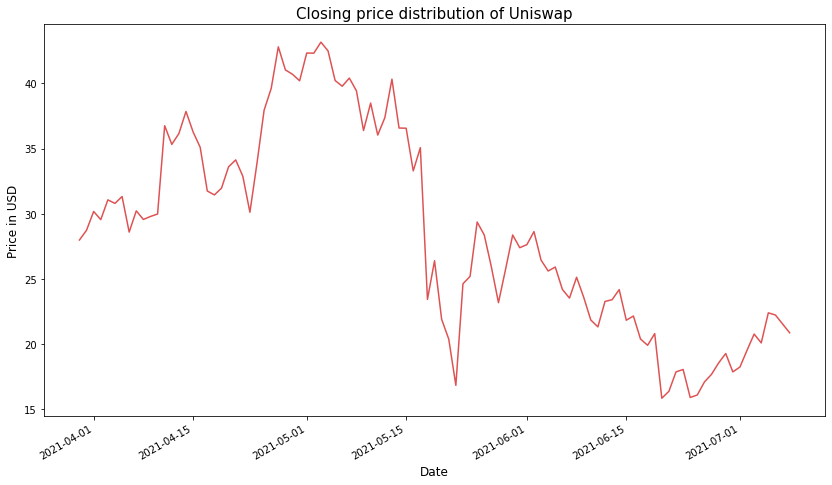

In [4]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.close.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of Uniswap", fontsize=15)
plt.show()

Text(0.5, 1.0, 'Daily price spread of Uniswap')

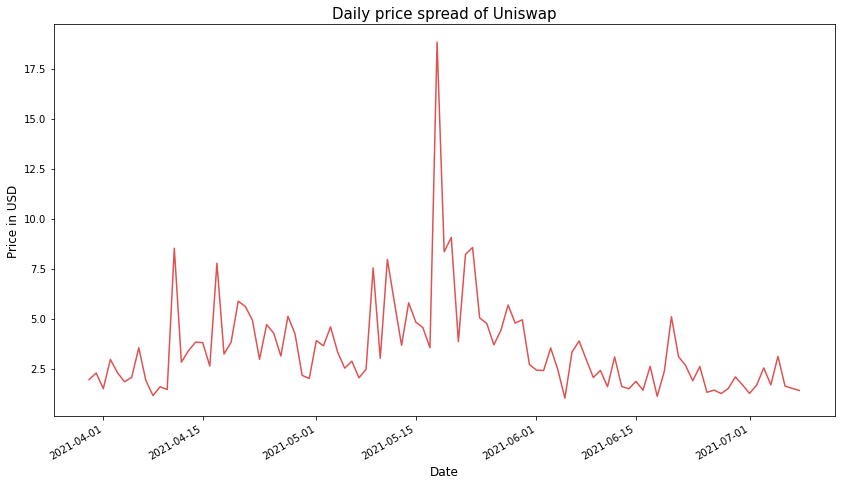

In [5]:
fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.spread.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Daily price spread of Uniswap", fontsize=15)

## Candlestick chart

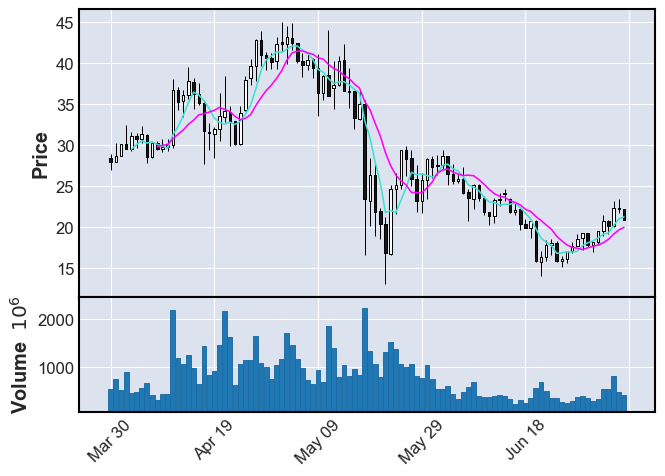

In [6]:
import matplotlib.ticker as mticker
import mplfinance as mpf

temp_base_df = base_df.copy(deep=False)

temp_base_df = temp_base_df.drop(['spread'], axis=1)
mpf.plot(temp_base_df.loc['2020-6-1':], type='candle', mav=(5,10), volume=True)

## Future Price Prediction

In [7]:
from fbprophet import Prophet

In [8]:
price_predict_df = base_df['close'].copy(deep=False).reset_index()
price_predict_df.columns = ["ds", "y"]
#price_predict_df = price_predict_df[price_predict_df['ds']>'2020-6-1']
price_predict_df

,ds,y
0,2021-03-30,27.986523
1,2021-03-31,28.739431
2,2021-04-01,30.175646
3,2021-04-02,29.549885
4,2021-04-03,31.065556
...,...,...
95,2021-07-03,20.771875
96,2021-07-04,20.095181
97,2021-07-05,22.400187
98,2021-07-06,22.231146


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
125,2021-08-03,18.653068,0.463182,36.231144
126,2021-08-04,18.748024,-0.220668,36.583380
127,2021-08-05,17.960022,-1.514055,37.443239
128,2021-08-06,16.920924,-3.984690,38.372030
129,2021-08-07,17.505556,-4.968037,39.814128


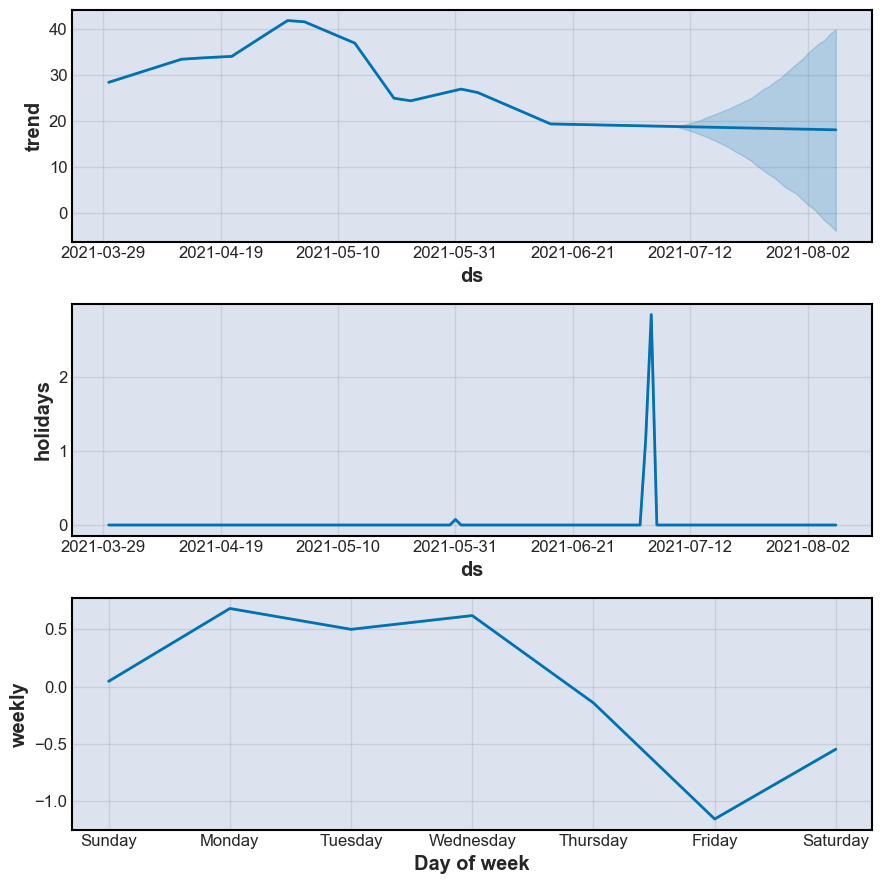

In [9]:
m = Prophet(changepoint_prior_scale=.7)
m.add_country_holidays(country_name='US')
#m.add_country_holidays(country_name='CN')
m.fit(price_predict_df);
m.train_holiday_names

future = m.make_future_dataframe(periods=30)

forecast = m.predict(future)
fig = m.plot_components(forecast)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

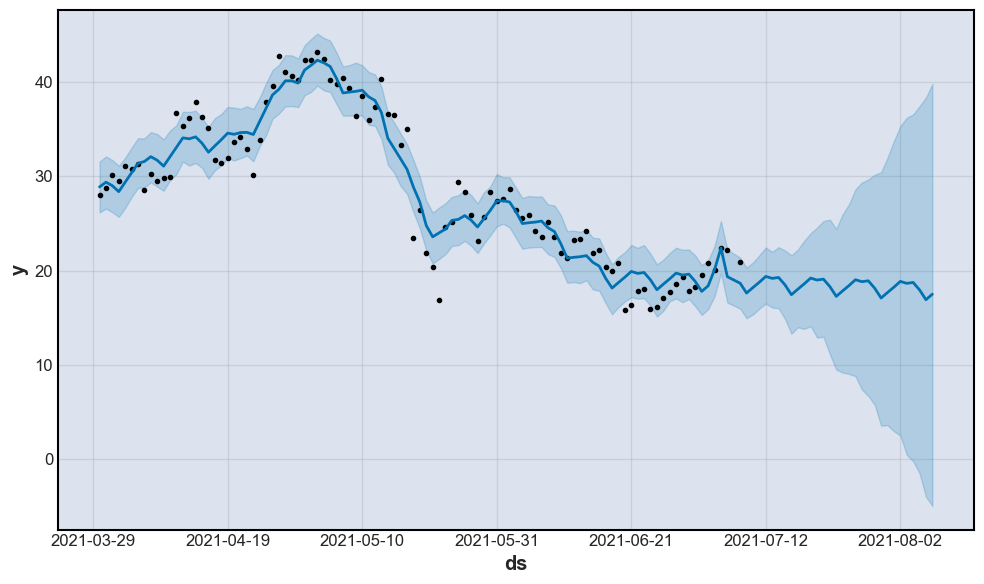

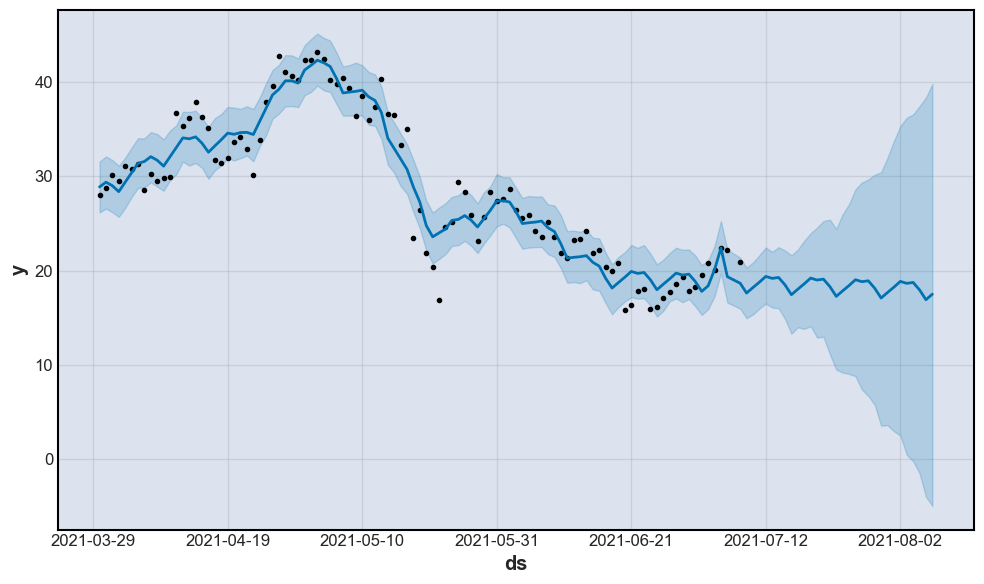

In [10]:
m.plot(forecast)